# Bibliotecas Utilizadas 

In [23]:
# Bibliotecas utilizadas
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import hamming_loss

import seaborn as sns
import matplotlib.pyplot as plt 

!pip install scikit-multilearn==0.2.0
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import ClassifierChain
from sklearn.metrics import hamming_loss
from skmultilearn.adapt import MLkNN
import pickle
from sklearn import metrics


# Dataset

Algoritmo que analisa o banco de dados do stackoverflow e classifica a qual tag pertence. Aqui vamos utilizar os algoritmos de classificação: Relevância Binária, Classificação em Cadeia e MLkNN e compará-los através de métricas relevantes. No final vamos testar o melhor algoritmo com a inserção de uma pergunta. 



### **Leitura do dataset**

In [2]:
#leitura do dataset
perguntas = pd.read_csv("dados/stackoverflow_perguntas.csv")
perguntas.head(5)

,Perguntas,Tags
0,Possuo um projeto Node.js porém preciso criar ...,node.js
1,"Gostaria de fazer testes unitários no Node.js,...",node.js
2,Como inverter a ordem com que o jQuery itera u...,jquery
3,Eu tenho uma página onde pretendo utilizar um ...,html
4,Como exibir os dados retornados do FireStore e...,html angular


### Limpeza dos dados

In [3]:
# dimensoes do dataframe
perguntas.shape

(5408, 2)

In [4]:
# dados nulos e faltantes
perguntas.isna().sum()

Perguntas    0
Tags         0
dtype: int64

In [5]:
perguntas.isnull().sum()

Perguntas    0
Tags         0
dtype: int64

In [6]:
# análise de categorias
print('As perguntas se encaixam em {} categorias'.format(len(perguntas.Tags.unique())))
perguntas['Tags'].unique()

As perguntas se encaixam em 37 categorias


array(['node.js', 'jquery', 'html', 'html angular ', 'html ', 'angular',
       'angular ', 'jquery html  ', 'jquery ', 'jquery html',
       'jquery html ', 'html angular', 'angular node.js ', 'html  ',
       'jquery html angular', 'node.js ', 'html jquery', 'html jquery ',
       'jquery angular  ', 'html node.js', 'jquery  ', 'angular node.js',
       'jquery angular', 'html node.js ', 'jquery node.js ', 'angular  ',
       'jquery angular ', 'jquery html angular ', 'node.js html ',
       ' node.js', 'node.js html', 'html angular  ', 'jquery node.js',
       'angular html', 'html angular  node.js', 'jquery html node.js',
       'html angular node.js'], dtype=object)

> Aqui notamos que temos diversas tags que são iguais e só diferem porque acrescentam mais informações. Vamos limpar isso.

### Engenharia de features

In [7]:
# função que mapeia quais tags temos no dataset
lista = list()
for tags in perguntas.Tags.unique():
    x = tags.split()
    for i in x:
        if i not in lista:
            lista.append(i)
lista

['node.js', 'jquery', 'html', 'angular']

In [8]:
# funcao que mapeia as tagas e cria uma coluna para cada uma no dataset mapeando a presença (1) e a não presença na frase (0)
def nova_coluna(dataframe, lista, nome_tag):
    for tag in lista:
        coluna = list()
        for linha in dataframe[nome_tag]:
            if tag in linha:
                coluna.append(1)
            else:
                coluna.append(0)

        #adicionado ao dataframe
        dataframe[tag] = coluna       
    return
nova_coluna(perguntas,lista,"Tags")

In [9]:
perguntas.head(3)

,Perguntas,Tags,node.js,jquery,html,angular
0,Possuo um projeto Node.js porém preciso criar ...,node.js,1,0,0,0
1,"Gostaria de fazer testes unitários no Node.js,...",node.js,1,0,0,0
2,Como inverter a ordem com que o jQuery itera u...,jquery,0,1,0,0


In [10]:
# para avançar é imprecindível ter todas as colunas dummies presentes em uma única coluna
# sendo assim, vamos juntar as colunas de Node.js, jquery, html e angular na coluna todas_tags
# aprendendo a utilizar o zip para juntas colunas no dataframe

#aplicando zip ao dataframe para juntar colunas
lista_zip_tags = list(zip(perguntas[lista[0]], 
                      perguntas[lista[1]],
                      perguntas[lista[2]],
                      perguntas[lista[3]])
                      )

#adicionando essa lista no datagrame
perguntas['todas_tags'] = lista_zip_tags

perguntas.head(2)

,Perguntas,Tags,node.js,jquery,html,angular,todas_tags
0,Possuo um projeto Node.js porém preciso criar ...,node.js,1,0,0,0,"(1, 0, 0, 0)"
1,"Gostaria de fazer testes unitários no Node.js,...",node.js,1,0,0,0,"(1, 0, 0, 0)"


In [11]:
sem_perguntas = perguntas.drop(['Perguntas','Tags'],axis=1)

In [12]:
#analisando a correlação entre as variáveis
perguntas.corr()

,node.js,jquery,html,angular
node.js,1.000000,-0.321485,-0.273523,-0.101787
jquery,-0.321485,1.000000,-0.253977,-0.366269
html,-0.273523,-0.253977,1.000000,-0.286706
angular,-0.101787,-0.366269,-0.286706,1.000000


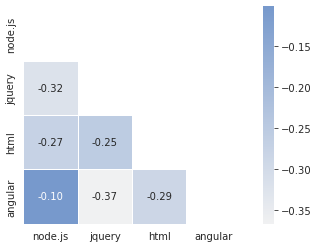

In [13]:
# criando um filtro para visualizar a matriz de correlação
#analisando a correlação entre as variáveis
correlacao = perguntas.corr()
cores = sns.light_palette("#79C",as_cmap=True)
mask = np.zeros_like(correlacao)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f,ax = plt.subplots(figsize=(8,4))
    ax = sns.heatmap(correlacao,mask=mask,cmap=cores,square=True,fmt='.2f',annot=True,linewidth=.5)

In [14]:
sem_perguntas.describe()

,node.js,jquery,html,angular
count,5408.000000,5408.000000,5408.000000,5408.000000
mean,0.118528,0.451923,0.433617,0.171783
std,0.323262,0.497729,0.495620,0.377226
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000




### **Dividindo nosso dataset**



In [15]:
#X_train, X_test, Y_train, Y_test

SEED = 123

X = perguntas['Perguntas']
y = perguntas['todas_tags']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=SEED)

In [16]:
X.shape

(5408,)


### **Variáveis Dummies para as perguntas**



Como o computador não entende o que significa a palavra "não" ou qualquer outra do nosso dataset, vamos utilizar a técnica TF-IDF. Ela atribui uma relevância para cada palavra nas perguntas.

O valor tf–idf (abreviação do inglês term frequency–inverse document frequency, que significa frequência do termo–inverso da frequência nos documentos), é uma medida estatística que tem o intuito de indicar a importância de uma palavra de um documento em relação a uma coleção de documentos ou em um corpus linguístico. Ela é frequentemente utilizada como fator de ponderação na recuperação de informações e na mineração de dados.

O valor tf–idf de uma palavra aumenta proporcionalmente à medida que aumenta o número de ocorrências dela em um documento, no entanto, esse valor é equilibrado pela frequência da palavra no corpus. Isso auxilia a distinguir o fato da ocorrência de algumas palavras serem geralmente mais comuns que outras.


In [17]:
#biblioteca utilizada para transformar as perguntas em vetor numéricos TfIdfVectorizer

vetorizar = TfidfVectorizer(max_features=5408,max_df=0.85) #vetor com o tamanho de 5000 e eliminando palavras que aparecem acima de 85% em cada pergunta

vetorizar.fit(X) 

#realizando a conversao das perguntas de treino e teste para linguagem de máquina
X_train_tfidf = vetorizar.transform(X_train)
X_test_tfidf = vetorizar.transform(X_test)

#dimensoes dos nossos vetores
print('>> As dimensões das perguntas de treino são:\n')
print(X_train_tfidf.shape)
print('\n>> As dimensões das perguntas de teste são:\n')
print(X_test_tfidf.shape)

>> As dimensões das perguntas de treino são:

(4326, 5408)

>> As dimensões das perguntas de teste são:

(1082, 5408)


# Modelagem dos dados



### **Algoritmo de classificação: Regressão Logística com OneVsRest**

*Esse algoritmo binário cria um modelo para cada categoria e classifica de acordo com 0(não presença) e 1(presença)*



> Métrica da qualidade do algoritmo: Extra-match (score)



In [18]:
# criando um classificador binário
regressao_logistica = LogisticRegression()

# como temos mais de 4 categorias, vamos utilizar o onevsrest para expandir para multiclasse
classificador_onevsrest = OneVsRestClassifier(regressao_logistica)

# antes de treinar o modelo vamos ter que converter a ultima coluna em um array ou matrix binária
y_train_array = np.asarray(list(y_train)) #temos que usar o list() pois se não teremos uma lista de tuplas
y_test_array = np.asarray(list(y_test))

# treinando 
classificador_onevsrest.fit(X_train_tfidf, y_train_array)

#agora predizendo o modelo através dos dados de teste, o score trás a acurácia
acuracia_onevsrest = classificador_onevsrest.score(X_test_tfidf, y_test_array) #nao é uma boa metrica, pois ela busca acertar 100% na variável

#predizendo nossas tags através das perguntas
previsao_onevsrest = classificador_onevsrest.predict(X_test_tfidf)

**Hamming Loss** = O hamming loss é uma métrica que avalia a precisão de um modelo multiclasse, no qual ele compara a quantidade de resultados incorretos com o número de resultados totais que o modelo pode dar. Então se é uma métrica que avalia a precisão do modelo, diminuímos ela melhorando a classificação do modelo.


In [24]:
#utilizando as tags de test e comparando com o valor previsto pelo classificador
hamming_loss_onevsrest = hamming_loss(y_test_array, previsao_onevsrest)
onevsrest_f1 =metrics.f1_score(y_test_array, previsao_onevsrest, average='micro')
print('hamming_loss do modelo OneVsRest é {0: .2f}'.format(hamming_loss_onevsrest))
print('f1 do modelo OneVsRest é {0: .2f}'.format(onevsrest_f1))
print("Acurácia do modelo {}%".format(acuracia_onevsrest*100))

hamming_loss do modelo OneVsRest é  0.19
f1 do modelo OneVsRest é  0.64
Acurácia do modelo 41.68207024029575%



### **Algoritmo de classificação Regressão Logística com Relevância Binária**

In [25]:
classificador_br = BinaryRelevance(regressao_logistica)
classificador_br.fit(X_train_tfidf,y_train_array)
resultado_br = classificador_br.score(X_test_tfidf, y_test_array) # acuracia
previsao_br = classificador_br.predict(X_test_tfidf)

In [26]:
br_f1=metrics.f1_score(y_test_array, previsao_br, average='micro')
br_hamm=metrics.hamming_loss(y_test_array,previsao_br)

In [27]:
print("Hamming Loss do modelo Relevância Binária {0: .2f}".format(br_hamm))
print('f1 do modelo Relevância Binária é {0: .2f}'.format(br_f1))
print("Acurácia do modelo {}%".format(resultado_br*100))

Hamming Loss do modelo Relevância Binária  0.19
f1 do modelo Relevância Binária é  0.64
Acurácia do modelo 41.68207024029575%



### **Algoritmo de classificação Regressão Logística com Classificação em Cadeia (ClassifierChain)**


*Esse algoritmo cria um modelo para cada tag. Esse algoritmo cria um modelo que analisa todas as 4 colunas*

In [28]:
#criando meu classificador multilabel
classificador_cadeia = ClassifierChain(regressao_logistica)

#treinando meus dados com esse classificador
classificador_cadeia.fit(X_train_tfidf, y_train_array)

#calculando a acurácia
resultado_cadeia = classificador_cadeia.score(X_test_tfidf, y_test_array)

#calculando o hamming loss
previsao_cadeia = classificador_cadeia.predict(X_test_tfidf)


In [29]:
br_f2=metrics.f1_score(y_test_array, previsao_cadeia, average='micro')
br_hamm2=metrics.hamming_loss(y_test_array,previsao_cadeia)

In [30]:
print("Hamming Loss do modelo Classificação em Cadeia {0: .2f}".format(br_hamm2))
print('f1 do modelo Classificação em Cadeia é {0: .2f}'.format(br_f2))
print("Acurácia do modelo {}%".format(resultado_cadeia*100))

Hamming Loss do modelo Classificação em Cadeia  0.21
f1 do modelo Classificação em Cadeia é  0.62
Acurácia do modelo 49.81515711645101%



### **Algoritmo de classificação Regressão Logística com Multi-label KNN (MLkNN)**

In [31]:
classificador_mlknn = MLkNN()
classificador_mlknn.fit(X_train_tfidf, y_train_array)
resultado_mlknn = classificador_mlknn.score(X_test_tfidf, y_test_array)
previsao_mlknn = classificador_mlknn.predict(X_test_tfidf)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass n_neighbors=10 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [32]:
br_f3=metrics.f1_score(y_test_array, previsao_mlknn, average='micro')
br_hamm3=metrics.hamming_loss(y_test_array,previsao_mlknn)

print("Hamming Loss do modelo Multilabel KNN {0: .2f}".format(br_hamm3))
print('f1 do modelo Multilabel KNN é {0: .2f}'.format(br_f3))
print("Acurácia do modelo {}%".format(resultado_mlknn*100))

Hamming Loss do modelo Multilabel KNN  0.25
f1 do modelo Multilabel KNN é  0.51
Acurácia do modelo 32.16266173752311%


# Comparando os modelos

In [33]:
f1       = (onevsrest_f1, br_f1, br_f2, br_f3)
hamming  = (hamming_loss_onevsrest ,br_hamm ,br_hamm2, br_hamm3)
acuracia = (acuracia_onevsrest, resultado_br, resultado_cadeia, resultado_mlknn)

In [34]:
dados = [f1,
         hamming,
         acuracia]

df = pd.DataFrame(dados)
df.rename(columns={0:'OneVsRest', 1:'Relevância Binária' ,2:'Classifier Chain', 3:'MlKnn'},inplace=True)
df.rename(index={0:'f1',1:'hamming loss',2:'acuracia'},inplace=True)
df

,OneVsRest,Relevância Binária,Classifier Chain,MlKnn
f1,0.635791,0.635791,0.616869,0.506511
hamming loss,0.187153,0.187153,0.210952,0.253928
acuracia,0.416821,0.416821,0.498152,0.321627


# Exportando o modelo

In [35]:
# salvando o modelo e vetorizados

# abrindo um arquivo
output = open('classificador_pergunta_stackoverflow','wb')
output_vet = open('vetorizar_dummie','wb')

# escrevendo
pickle.dump(vetorizar, output_vet)
pickle.dump(classificador_onevsrest,output)

# fechando
output_vet.close()
output.close()

# Classificando uma frase

In [36]:
from itertools import repeat
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer

# abrindo o modelo e o vetorizador 
predict_model = open('classificador_pergunta_stackoverflow','rb')
vetorizar = open('vetorizar_dummie','rb')

# carregando
vetorizar_dummie = pickle.load(vetorizar)
modelo = pickle.load(predict_model)

# fechando
vetorizar.close()
predict_model.close()

In [37]:
# inserindo a frase
phrase = ["meu codigo em html travou quando abri o <p> </p>"]

In [38]:
phrase_transformada = vetorizar_dummie.transform(phrase) 

In [39]:
predicao = modelo.predict(phrase_transformada)

In [40]:
predicao

array([[0, 0, 1, 0]])